# Derived Fields and Profiles

One of the most powerful features in yt is the ability to create derived fields that act and look exactly like fields that exist on disk.  This means that they will be generated on demand and can be used anywhere a field that exists on disk would be used.  Additionally, you can create them by just writing python functions.

In [12]:
%matplotlib inline
import yt
import numpy as np
from yt import derived_field
from matplotlib import pylab
import analysis_schema

## Derived Fields

This is an example of the simplest possible way to create a derived field.  All derived fields are defined by a function and some metadata; that metadata can include units, LaTeX-friendly names, conversion factors, and so on.  Fields can be defined in the way in the next cell.  What this does is create a function which accepts two arguments and then provide the units for that field.  In this case, our field is `dinosaurs` and our units are `K*cm/s`.  The function itself can access any fields that are in the simulation, and it does so by requesting data from the object called `data`.

In [2]:
@derived_field(name = "dinosaurs", units = "K * cm/s")
def _dinos(field, data):
    return data["temperature"] * data["velocity_magnitude"]

/Users/swalkow2/anaconda3/lib/python3.7/site-packages/yt/fields/local_fields.py:46: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
  warnings.warn("Because 'sampling_type' not specified, yt will "


One important thing to note is that derived fields must be defined *before* any datasets are loaded.  Let's load up our data and take a look at some quantities.

In [3]:
ds = yt.load("IsolatedGalaxy/galaxy0030/galaxy0030")
dd = ds.all_data()
print (list(dd.quantities.keys()))

yt : [INFO     ] 2020-06-01 10:19:27,480 Parameters: current_time              = 0.0060000200028298
yt : [INFO     ] 2020-06-01 10:19:27,481 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2020-06-01 10:19:27,482 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2020-06-01 10:19:27,485 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2020-06-01 10:19:27,488 Parameters: cosmological_simulation   = 0.0


['WeightedAverageQuantity', 'TotalQuantity', 'TotalMass', 'CenterOfMass', 'BulkVelocity', 'WeightedVariance', 'AngularMomentumVector', 'Extrema', 'SampleAtMaxFieldValues', 'MaxLocation', 'SampleAtMinFieldValues', 'MinLocation', 'SpinParameter']


One interesting question is, what are the minimum and maximum values of dinosaur production rates in our isolated galaxy?  We can do that by examining the `extrema` quantity -- the exact same way that we would for density, temperature, and so on.

In [4]:
print (dd.quantities.extrema("dinosaurs"))

Parsing Hierarchy : 100%|██████████| 173/173 [00:00<00:00, 4689.61it/s]
yt : [INFO     ] 2020-06-01 10:19:31,315 Gathering a field list (this may take a moment.)


[3.31419530e+04 1.18723107e+15] K*cm/s


We can do the same for the average quantities as well.

In [5]:
print (dd.quantities.weighted_average_quantity("dinosaurs", weight="temperature"))

16822848849458.07 K*cm/s


## A Few Other Quantities

We can ask other quantities of our data, as well.  For instance, this sequence of operations will find the most dense point, center a sphere on it, calculate the bulk velocity of that sphere, calculate the baryonic angular momentum vector, and then the density extrema.  All of this is done in a memory conservative way: if you have an absolutely enormous dataset, yt will split that dataset into pieces, apply intermediate reductions and then a final reduction to calculate your quantity.

## <font color='red'> converting another sphere </font>

In [6]:
sp = ds.sphere("max", (10.0, 'kpc'))
bv = sp.quantities.bulk_velocity()
L = sp.quantities.angular_momentum_vector()
rho_min, rho_max = sp.quantities.extrema("density")
print (bv)
print (L)
print (rho_min, rho_max)

yt : [INFO     ] 2020-06-01 10:19:39,998 Max Value is 7.73427e-24 at 0.5040893554687501 0.4998168945312501 0.5001831054687500


[-892739.08777744 1107086.20621902  620738.20523762] cm/s
[-5.01415153e+25  7.51695813e+26  4.16988689e+28] cm**2/s
2.214782381237793e-28 g/cm**3 7.73426503924e-24 g/cm**3


In [14]:
sphere_schema = analysis_schema.Sphere(center= analysis_schema.UnitfulCoordinate(unit="unitary",
                                                                                 values =[0.5, 0.5, 0.5]), 
                                       radius=analysis_schema.UnitfulValue(unit="kpc", value=10.0))

In [19]:
sphere_schema.json()

'{"center": {"values": [0.5, 0.5, 0.5], "unit": "unitary"}, "radius": {"value": 10.0, "unit": "kpc"}}'

In [18]:
sphere_schema.schema_json()

'{"title": "Sphere", "type": "object", "properties": {"center": {"$ref": "#/definitions/UnitfulCoordinate"}, "radius": {"$ref": "#/definitions/UnitfulValue"}}, "required": ["center", "radius"], "definitions": {"UnitfulCoordinate": {"title": "UnitfulCoordinate", "type": "object", "properties": {"values": {"title": "Values", "default": [0.5, 0.5, 0.5], "minItems": 3, "maxItems": 3, "type": "array", "items": {"type": "number"}}, "unit": {"title": "Unit", "default": "unitary", "type": "string"}}}, "UnitfulValue": {"title": "UnitfulValue", "type": "object", "properties": {"value": {"title": "Value", "type": "number"}, "unit": {"title": "Unit", "default": "unitary", "type": "string"}}, "required": ["value"]}}}'

## Profiles

yt provides the ability to bin in 1, 2 and 3 dimensions.  This means discretizing in one or more dimensions of phase space (density, temperature, etc) and then calculating either the total value of a field in each bin or the average value of a field in each bin.

We do this using the objects `Profile1D`, `Profile2D`, and `Profile3D`.  The first two are the most common since they are the easiest to visualize.

This first set of commands manually creates a profile object the sphere we created earlier, binned in 32 bins according to density between `rho_min` and `rho_max`, and then takes the density-weighted average of the fields `temperature` and (previously-defined) `dinosaurs`.  We then plot it in a loglog plot.

Text(0, 0.5, 'Temperature $(K)$')

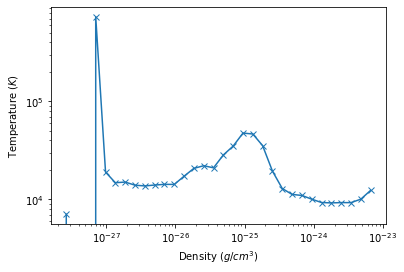

In [7]:
prof = yt.Profile1D(sp, "density", 32, rho_min, rho_max, True, weight_field="cell_mass")
prof.add_fields(["temperature","dinosaurs"])
pylab.loglog(np.array(prof.x), np.array(prof["temperature"]), "-x")
pylab.xlabel('Density $(g/cm^3)$')
pylab.ylabel('Temperature $(K)$')

Now we plot the `dinosaurs` field.

Text(0, 0.5, 'Dinosaurs $(K cm / s)$')

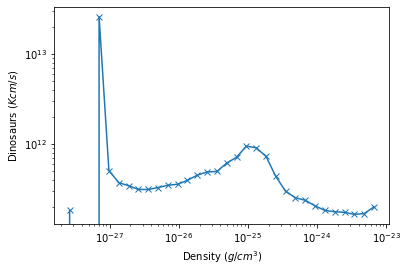

In [8]:
pylab.loglog(np.array(prof.x), np.array(prof["dinosaurs"]), '-x')
pylab.xlabel('Density $(g/cm^3)$')
pylab.ylabel('Dinosaurs $(K cm / s)$')

If we want to see the total mass in every bin, we profile the `cell_mass` field with no weight.  Specifying `weight=None` will simply take the total value in every bin and add that up.

Text(0, 0.5, 'Cell mass $(M_\\odot)$')

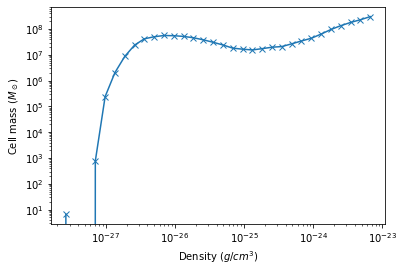

In [9]:
prof = yt.Profile1D(sp, "density", 32, rho_min, rho_max, True, weight_field=None)
prof.add_fields(["cell_mass"])
pylab.loglog(np.array(prof.x), np.array(prof["cell_mass"].in_units("Msun")), '-x')
pylab.xlabel('Density $(g/cm^3)$')
pylab.ylabel('Cell mass $(M_\odot)$')

In addition to the low-level `ProfileND` interface, it's also quite straightforward to quickly create plots of profiles using the `ProfilePlot` class.  Let's redo the last plot using `ProfilePlot`


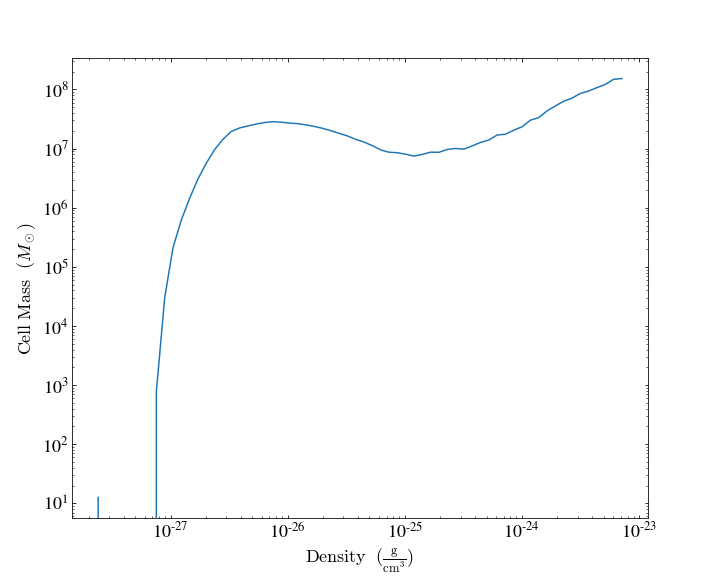

In [10]:
prof = yt.ProfilePlot(sp, 'density', 'cell_mass', weight_field=None)
prof.set_unit('cell_mass', 'Msun')
prof.show()

## <font color='red'> Tried to combine a profile (a sphere) with a profile splot schema </font>

In [34]:
prof_schema = analysis_schema.ProfilePlot(profiles=[sphere_schema])

In [35]:
prof_schema.json()

'{"profiles": [{}], "x_log": null, "y_log": null, "x_title": null, "y_title": null}'

## Field Parameters

Field parameters are a method of passing information to derived fields.  For instance, you might pass in information about a vector you want to use as a basis for a coordinate transformation.  yt often uses things like `bulk_velocity` to identify velocities that should be subtracted off.  Here we show how that works:

In [11]:
sp_small = ds.sphere("max", (50.0, 'kpc'))
bv = sp_small.quantities.bulk_velocity()

sp = ds.sphere("max", (0.1, 'Mpc'))
rv1 = sp.quantities.extrema("radial_velocity")

sp.clear_data()
sp.set_field_parameter("bulk_velocity", bv)
rv2 = sp.quantities.extrema("radial_velocity")

print (bv)
print (rv1)
print (rv2)

yt : [INFO     ] 2020-06-01 10:19:50,224 Max Value is 7.73427e-24 at 0.5040893554687501 0.4998168945312501 0.5001831054687500
yt : [INFO     ] 2020-06-01 10:19:52,143 Max Value is 7.73427e-24 at 0.5040893554687501 0.4998168945312501 0.5001831054687500


[ -8934.11243694 198277.64189059 311013.85834147] cm/s
[-69582773.17816047  32330373.38084772] cm/s
[-69649428.21589643  32236297.22862704] cm/s
